<center><h1>N3: Métodos de análisis de componentes</h1></center>

# N3: Métodos de análisis de componentes

# RECUERDA RELLENAR TUS DATOS A CONTINUACIÓN ANTES DE HACER NADA

In [ ]:
# ===============================================================#
# Rellena AQUÍ tu nombre y apellidos antes de hacer nada
# ===============================================================#

NOMBRE = 'Mayra'
APELLIDOS = 'Pullupaxi'

# ===============================================================#

El análisis de componentes principales (PCA, por sus siglas en inglés) es una técnica que, a través de transformaciones lineales de los datos, representa los datos originales a través de una serie de dimensiones alternativas. Se usa para simplemente para reorganizar los datos e identificar variables relevantes o para reducir la dimensionalidad (encontrando las componentes de mayor varianza en las que proyectamos los datos para reducir el número de dimensiones con la menor pérdida de información posible).

En este tutorial, veremos cómo se lleva a cabo paso a paso. Empezamos cargando las librerías necesarias y los datos que utilizaremos en este ejemplo: el famoso dataset Iris de la UCI, que describe diferentes muestras de tres tipos de flores usando 4 variables.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv(filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, sep=',')
df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

# Guardamos los datos en un formato matricial 
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
yvals = np.unique(y)


Podemos ver que las diferentes variables discriminan en diferente grado los diferentes tipos de flores usando los siguientes histogramas:


/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

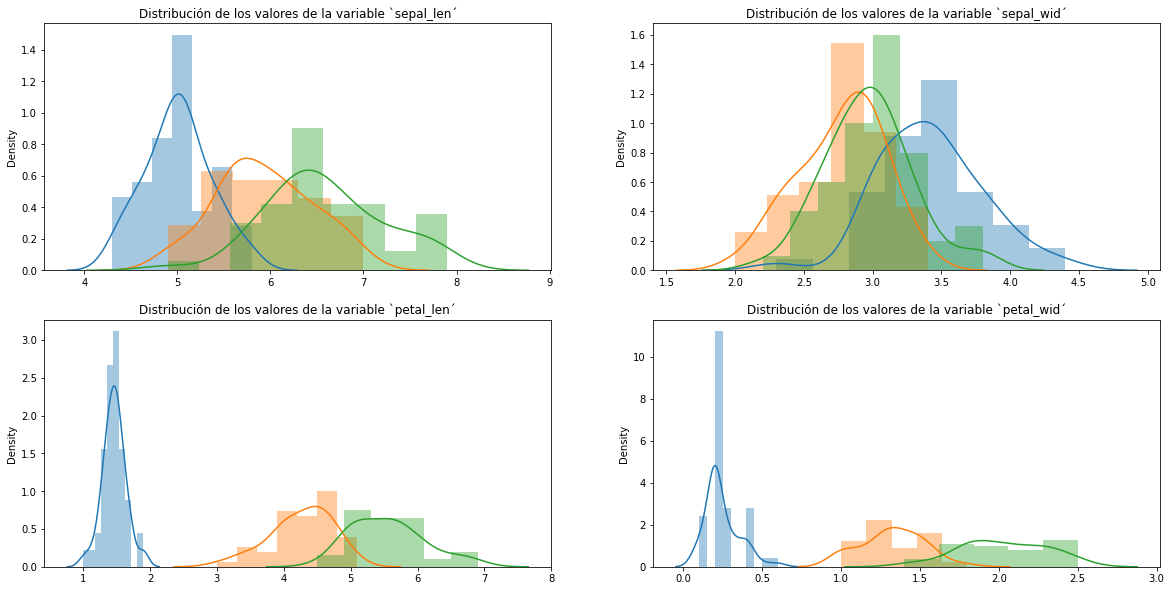

In [2]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))

for i in np.arange(2):
    for j in np.arange(2):
        for c in np.arange(len(yvals)):
            ax[i,j].set_title("Distribución de los valores de la variable `"+df.columns[i*2+j]+"´")
            sns.distplot(X[y==yvals[c],i*2+j], ax=ax[i,j], norm_hist=True, kde=True)


Se puede apreciar que mientras entre las variables <i>sepal_len</i> y <i>sepal_width</i> no hay una relación directamente observable, entre las variables <i>petal_len</i> y <i>petal_wid</i> sí que es evidente.

<hr />

En este tutorial nos centraremos en el uso de PCA para la reducción de dimensionalidad. En este caso, queremos transformar el espacio actual de $d$ dimensiones en otro de $k$ donde $k<d$, pero con la menor pérdida de información posible. Hay dos cuestiones que aparecen de manera natural tras esta afirmación:

- ¿Cómo vamos a obtener las nuevas dimensiones (variables)?
- ¿Cuántas de las nuevas dimensiones (valor $k$) debería conservar para minimizar la pérdida de información?

La respuesta a la primera pregunta es: mediante los vectores propios de la matriz de covarianzas de los datos originales. La respuesta a la segunda pregunta es más subjetiva, pero dependerá de la cantidad de varianza acumulada por las componentes principales. Es decir, eliminaremos las componentes (vectores propios) menos informativas.


<h2>PCA: en la práctica</h2>

En la práctica, la aplicación de PCA se plasma en los siguiente pasos:

- Estandarizamos los datos y obtenemos la matriz de covarianzas, $\Sigma$
- Calculamos los vectores y valores propios de  $\Sigma$
- Dado $k<d$, seleccionamos los primeros $k$ vectores propios ordenados según su valor propio y construimos una matriz de proyección $P$ de tamaño $d\times k$
- Transformar los datos originales estandarizados $\mathbf{X_p}$ aplicando $P$ para obtener la matriz de datos transformada

El primer paso, así, es estandarizar los datos (todas las variables tienen media 0 y desviación estándar 1 tras la operación) que se puede hacer usando la función que ya incorpora, por ejemplo, la librería scikit-learn:

In [3]:
from sklearn.preprocessing import StandardScaler

Xp = StandardScaler().fit_transform(X)


Una vez disponemos de los datos estandarizados, podemos proceder al cálculo de la matriz de covarianzas, $\Sigma$. Ésta es una matriz cuadrada de dimensiones $d\times d$ que guarda la covarianza ($E[(X_j-X_k)^2]$) entre todos los pares de variables posibles. La covarianza entre dos variables concretas, $X_j$ y $X_k$, se calcula en la práctica de la siguiente manera:

$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{n} (  x_{ij}-\bar{x}_j )  ( x_{ik}-\bar{x}_k )$$

donde $\bar{x}_j$ es el valor medio de la variable $X_j$ y $\bar{x}_k$ lo es de la variable $X_k$. En forma matricial, podemos condensar todos los cálculos para todos los pares de variables por medio de la siguiente fórmula:
$$\Sigma = \frac{1}{n-1} (\mathbf{X} - \mathbf{\bar{x}})^T(\mathbf{X} - \mathbf{\bar{x}})$$
donde $\mathbf{\bar{x}}$ es el vector de valores medios para todas las variables, $\mathbf{\bar{x}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_{i}$.  

El cálculo se puede resumir en dos pasos: la obtención del vector de medias y la de la matriz de covarianzas:

In [4]:
# vector de medias por variable
xm = np.mean(Xp, axis=0)
# matriz de covarianzas
mCovarianzas = np.dot((Xp - xm).T, (Xp - xm)) / (Xp.shape[0]-1)
print('La matriz de covarianzas del dataset Iris es:\n%s' %mCovarianzas)

La matriz de covarianzas del dataset Iris es:
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]



Como es de esperar, este cálculo ya está integrado en librería como Numpy:


In [5]:
print('NumPy covariance matrix: \n%s' %np.cov(Xp.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]



Tras calcula la matriz de covarianzas, el siguiente paso consiste en obtener la descomposición en vectores y valores propios de dicha matriz. Para ello, utilizaremos el método `np.linalg.eig`y lo aplicaremos a la matriz de covarianzas `np.linalg.eig`.


In [13]:
# P1
valsPr, vecsPr = np.linalg.eig(mCovarianzas)## P1. Tu código aquí ##

print('Vectores propios:\n%s' %vecsPr)
print('Valores propios:\n%s' %valsPr)

Vectores propios:
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Valores propios:
[2.93035378 0.92740362 0.14834223 0.02074601]



Nótese que el número de vectores propios (columnas de la matriz <i>vecsPr</i>) y valores propios es igual al número de dimensiones de la matriz original, $d$. Usar la matriz de vector propios completa como matriz de proyección daría como resultado una nueva matriz de datos en los que éstos se encuentran rotados y alineados con respecto a los nuevos ejes, pero no habría ningún tipo de pérdida de información.

La obtención de los valores y vectores propios es el paso clave de PCA. Por un lado, se obtienen los vectores que definen los nuevos ejes (dimensiones, variables) del conjunto de datos transformados. Estos vectores definen simplemente una combinación lineal de los ejes originales. Por su parte, los valores propios indican la relevancia de cada una de las nuevas dimensiones o ejes. Concretamente, cada valor propio determina la cantidad de varianza presente en el dataset original que se podría explicarse por medio del eje correspondiente.



El siguiente paso consiste en elegir cuántos vectores propios vamos a conservar y cuántos, por el contrario, vamos a descartar. La idea es eliminar aquellos que aportan menos información pero, ¿cuánta información estamos dispuestos a perder?

Vamos a observar algunas características de esta transformación:


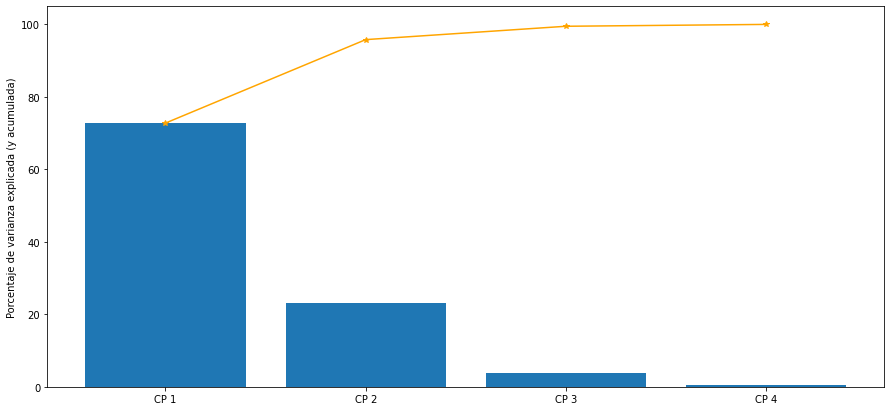

Valores propios ordenados y porcentaje de varianza explicada:
CP1: Valor propio = 2.9304; Porcentaje de varianza explicada = 72.770
CP2: Valor propio = 0.9274; Porcentaje de varianza explicada = 23.031
CP3: Valor propio = 0.1483; Porcentaje de varianza explicada = 3.684
CP4: Valor propio = 0.0207; Porcentaje de varianza explicada = 0.515


In [14]:
# Juntamos los vectores y los valores propios correspondientes y los ordenamos
valsVectPr = [(np.abs(valsPr[i]), vecsPr[:,i]) for i in np.arange(len(valsPr))]
valsVectPr.sort(reverse=True)

totalVarianza = np.sum(valsPr)
varianzaPorComp = [100 * valsVectPr[i][0] / totalVarianza 
                   for i in np.arange(len(valsVectPr))]
varianzaPorCompAcumulada = np.cumsum(varianzaPorComp)

# Mostramos la varianza explicada por cada nuevo eje o componente 
# mediante un diagrama de barras y el acumulado de manera superpuesta
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(np.arange(len(valsVectPr)), varianzaPorComp)
plt.xticks(np.arange(len(valsVectPr)), ('CP 1', 'CP 2', 'CP 3', 'CP 4'))

plt.plot(varianzaPorCompAcumulada,'*-', c='orange')
plt.ylabel('Porcentaje de varianza explicada (y acumulada)')
plt.show()


print('Valores propios ordenados y porcentaje de varianza explicada:')
for i in np.arange(len(valsVectPr)):
    print("CP{0:d}: Valor propio = {1:1.4f}; Porcentaje de varianza explicada = {2:2.3f}".format
          (i+1, valsVectPr[i][0], varianzaPorComp[i]))


Se puede observar que la primera componente principal explica más del $70\%$ de la varianza total, mientras que la segunda explica más del $20\%$. La tercera no llega al $4\%$ y la última está incluso por debajo del $1\%$.

Si nos quedásemos con las dos primeras ($k=2$), conseguiríamos una representación de los datos (transformación) que explica el $95.8\%$ de la varianza de los datos originales. Si usásemos las tres primeras componentes ($k=3$), este porcentaje subiría hasta el $99.4\%$, aunque la reducción de dimensionalidad sería de menor envergadura (pasaríamos de 4 dimensiones a 3).

Un umbral habitual suele ser conseguir explicar el $95\%$ de los datos, por lo que procederemos seleccionando sólo dos componentes principales ($K=2$).



El último paso consiste en construir una matriz de proyección compuesta por los vectores propios (ejes-componentes de la nueva matriz transformada). El producto matricial de la matriz de datos original por la matriz de proyección nos devolverá la matriz de datos transformada:

$$\mathbf{Xt} = \mathbf{X_p} \times \mathbf{P}$$


In [32]:
k = 2

# Componemos la matriz de proyección con los vectores propios seleccionados
mProyeccion = valsVectPr[0][1].copy()
for i in np.arange(1,k):
    mProyeccion = np.vstack((mProyeccion, valsVectPr[i][1]))
mProyeccion=mProyeccion.T
print("La matriz de proyección es:\n%s"%mProyeccion)

# Obtenemos la matriz de datos transformada

# P2
Xt = np.matmul(Xp, mProyeccion)## P2. Tu código aquí ##

print("La nueva matriz de datos tiene unas dimensiones de {0:d} casos por {1:d} variables".format(*Xt.shape))
print("El valor del último ejemplo para la primera componente es:",Xt[149,0])

La matriz de proyección es:
[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]
La nueva matriz de datos tiene unas dimensiones de 150 casos por 2 variables
El valor del último ejemplo para la primera componente es: 0.9592985756160382


Finalmente, podemos observar de manera similar cómo lucen las nuevas dimensiones:


/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

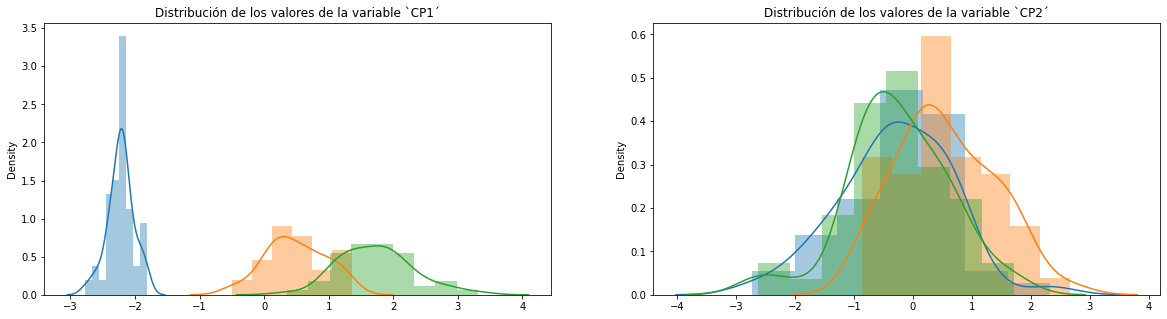

In [33]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))

for i in np.arange(2):
    for c in np.arange(len(yvals)):
        ax[i].set_title("Distribución de los valores de la variable `CP"+str(i+1)+"´")
        sns.distplot(Xt[y==yvals[c],i], ax=ax[i], norm_hist=True, kde=True)


Comparando éstas con las variables originales, se puede apreciar que la componente principal 1 agrupa la información de las variables originales <i>petal_len</i> y <i>petal_wid</i>, mientras que la CP2 se parece en mayor medida a las variables <i>sepal_len</i> y <i>sepal_width</i>.


<h1>Implementaciones en librerías de Python</h1>

Librerías de Python como Scikit-learn ya incluyen su propia implementación del PCA:


In [34]:
from sklearn.decomposition import PCA

# Podemos indicar el número de componentes con las que nos 
# queremos quedar o bien el porcentaje de varianza que queremos 
# que quede explicada 

k = 2
sklearn_pca = PCA(k)

# porcentajeVE = 0.95
# sklearn_pca = PCA(porcentajeVE)

# P3
Xt_sk = sklearn_pca.fit_transform(Xp)## P3. Tu código aquí ##


Las componentes que se obtienen con sklearn lucen de la siguiente manera:


/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

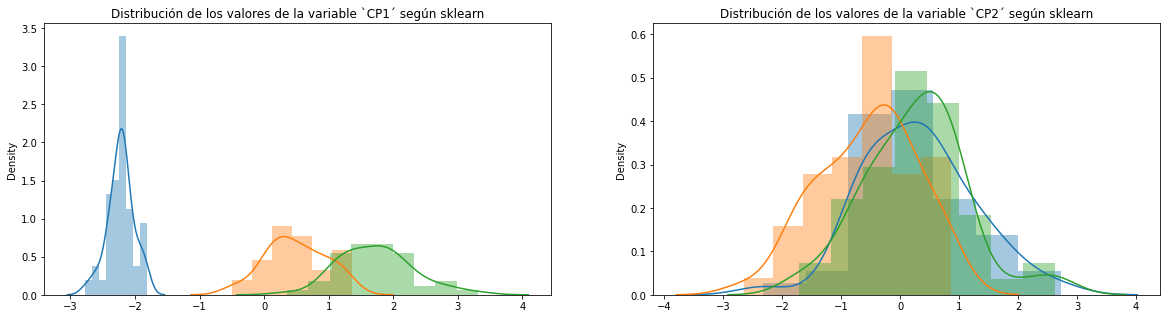

In [35]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))

for i in np.arange(2):
    for c in np.arange(len(yvals)):
        ax[i].set_title("Distribución de los valores de la variable `CP"+str(i+1)+"´ según sklearn")
        sns.distplot(Xt_sk[y==yvals[c],i], ax=ax[i], norm_hist=True, kde=True)

<hr />
<center><h1>PCA en la práctica: mejora del rendimiento</h1></center>

Para acabar con este tutorial, vamos a probar el algoritmo PCA en un problema real y comprobar cómo su uso puede mejorar el rendimiento de cálculos posteriores. En este caso, vamos a aplicar PCA para reducir la dimensionalidad de un dataset clásico (MNIST) y, posteriormente, aprender un clasificador.

MNIST es un dataset que contiene unos $70000$ dígitos manuscritos, todos ellos representados por medio $784$ dimensiones. Cada dimensión contiene el color en escala de grises (0..255) de un pixel en concreto (las imágenes son de 28x28 píxeles). Hay 10 clases, que representan cada uno de los dígitos entre 0 y 9.

Empezaremos por cargar los datos desde OpenML usando la API que integra Scikit-learn:


In [26]:
from sklearn.datasets import fetch_openml

dataset, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

print('Las dimensiones de la matriz X de variables descriptivas es:',dataset.shape)
print('El tamaño del vector de etiquetas asociado es:',labels.shape)

Las dimensiones de la matriz X de variables descriptivas es: (70000, 784)
El tamaño del vector de etiquetas asociado es: (70000,)



Tras cargar los datos, la primera acción será dividir el dataset en una partición para aprendizaje y otra para test. Guardaremos $1/7$ de los datos para test ($10000$ ejemplos) y el resto los usaremos para aprendizaje.


In [27]:
from sklearn.model_selection import train_test_split

trDataset, tsDataset, trLabels, tsLabels = train_test_split(dataset, labels, 
                                                            test_size=1/7.0, random_state=0)


Siguiendo los puntos que comentábamos anteriormente, el primer paso es la estandarización de los datos. En este caso, aprenderemos los parámetros necesarios sólo a partir de los datos de aprendizaje ya que no queremos información del conjunto de test en nuestro entrenamiento!


In [28]:
# Usamos la función de estandarización de ScikitLearn
estandarizador = StandardScaler()

# Aprendemos la media y varianza de cada variable teniendo 
# en cuenta sólo los datos de aprendizaje
estandarizador.fit(trDataset)

# Y llevamos a cabo, con esos valores, la estandarización 
# de los dos subconjuntos (training y test)
trDataset = estandarizador.transform(trDataset)
tsDataset = estandarizador.transform(tsDataset)


Vamos a usar la función de scikit-learn para realizar el PCA. Esta función acepta dos parámetros complementarios: le podemos decir el número de componentes que queremos conservar (como en el ejemplo anterior con el dataset Iris) o el porcentaje de varianza explicada que queremos conservar (el número de componentes necesarias se calcula en base a ello).

En este caso, le decimos que queremos un número de componentes que nos garanticen al menos un cierto umbral de varianza (mínima) explicada. Vamos a probar varios umbrales para observar el efecto que esto tiene en el número de componentes obtenidas y en el rendimiento de un clasificador aprendido con los datos transformados resultantes:


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import timeit

for porc in np.arange(5):
    
    porcentajeVE = 1 - porc * .2 - 0.000001

    pca = PCA(porcentajeVE)

    # De manera análoga, aprendemos los parámetros (las componentes, en este 
    # caso) a partir de los datos de entrenamiento únicamente, y aplicamos la 
    # transformación a los dos subconjuntos (training y test)
    pca.fit(trDataset)

    trTransDataset = pca.transform(trDataset)
    tsTransDataset = pca.transform(tsDataset)
    
    tiempo = timeit.default_timer()

    # Aprendemos el clasificado (regresión logística)
    logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')
    logisticRegr.fit(trTransDataset, trLabels)
    
    # Usamos el clasificador para predecir sobre el dataset de test
    predLabels = logisticRegr.predict(tsTransDataset)
    
    # Medimos el rendimiento del clasificador 
    accuracy = accuracy_score(tsLabels, predLabels)
    f1 = f1_score(tsLabels, predLabels, average='macro')
    
    tiempo = timeit.default_timer() - tiempo

    print('Prueba no. {0:d}: {1:d}% de varianza explicada'.format(porc+1, int(np.round(100*porcentajeVE))))
    print(" + No. de componentes necesario:",pca.n_components_)
    print(" + Clasificador aprendido con estos datos:")
    print("    - Tiempo necesario (s.)  : {0:2.2f}".format(tiempo))
    print("    - Rendimiento (accuracy) : {0:2.5f}".format(accuracy))
    print("    - Rendimiento (medida F1): {0:2.5f}".format(f1))
    print()

/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prueba no. 1: 100% de varianza explicada
 + No. de componentes necesario: 707
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 15.22
    - Rendimiento (accuracy) : 0.91260
    - Rendimiento (medida F1): 0.91116



/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prueba no. 2: 80% de varianza explicada
 + No. de componentes necesario: 146
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 4.93
    - Rendimiento (accuracy) : 0.91730
    - Rendimiento (medida F1): 0.91577



/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prueba no. 3: 60% de varianza explicada
 + No. de componentes necesario: 62
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 4.08
    - Rendimiento (accuracy) : 0.90650
    - Rendimiento (medida F1): 0.90466



/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prueba no. 4: 40% de varianza explicada
 + No. de componentes necesario: 23
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 3.18
    - Rendimiento (accuracy) : 0.87060
    - Rendimiento (medida F1): 0.86811

Prueba no. 5: 20% de varianza explicada
 + No. de componentes necesario: 6
 + Clasificador aprendido con estos datos:
    - Tiempo necesario (s.)  : 2.50
    - Rendimiento (accuracy) : 0.73540
    - Rendimiento (medida F1): 0.72885



/Users/mayrita/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Es interesante observar que, en este caso, a pesar de la reducción de hasta un $40\%$ de la varianza explicada, los resultados de los clasificadores apenas se ven afectados. Es a partir de una reducción de la varianza mayor del $50\%$ cuando, en este caso, el clasificador aprendido empieza a resentirse. Mientras tanto, el coste computacional se ha reducido por 5.
